# Homework 1: Drive Ya' Nuts
### COSI 101A, Professor Jordan Pollack
### By Ari Porad
### March 9th, 2021

## Test Puzzle / `main()`
First and foremost, let's start by solving the provided test problem. Afterwards, we'll have some discussion go through each step of the homework in order.

In [1]:
# Let's import some dependencies
import matplotlib.pyplot as plt
from operator import add
from main import *

In [2]:
# Now, we can solve run the test puzzle
print("Test Puzzle:")
print(TEST_PUZZLE)

# The following is also defined as main() in main.py. It's copied here for clarity.
solution = solve_puzzle(TEST_PUZZLE)
print(f"Solution Found: {solution}")
print_hexnut_solution(solution)

Test Puzzle:
[(1, 6, 5, 4, 3, 2), (1, 6, 4, 2, 5, 3), (1, 2, 3, 4, 5, 6), (1, 6, 2, 4, 5, 3), (1, 4, 3, 6, 5, 2), (1, 4, 6, 2, 3, 5), (1, 6, 5, 3, 2, 4)]
Solution Found: State: SOLUTION; C: 1/6/2/4/5/3; Placed: 1/4/6/2/3/5, 6/5/3/2/4/1, 2/1/4/3/6/5, 4/5/6/1/2/3, 5/3/1/6/4/2, 3/2/1/6/5/4; Remaining: -

    6 5     6 2     
   1   4   4   3    
    2 3     1 5     
                          
 4 2     3 1     5 3 
6   5   5   6   6   2 
 1 3     4 2     1 4  
                      
    3 4      2 1     
   2   5    5   4    
    1 6      6 3     
	


## Discussion

For this homework, I built a puzzle solver based on a depth-first search of the state tree. For a given puzzle, the state tree is initialized with a root state, which specifies that all nuts are yet to be placed. From the root state, the solver iteratively generates the successor states of the current state and pushes them onto the stack of states to be evaluated, thereby conducting a depth-first search with appropriate backtracking. An iterative design is used over a recursive one in order to avoid stack overflow errors, which occurred continuously under a previous recursive design.

A state is represented by an instance of the `State` class. A key design decision in this solver is that an incomplete state and a complete solution are represented by the same object, and consequently most properties of a `State` may be `None` (as a practical matter, lists default to an empty list instead of `None`). A `State` contains the center nut, a list of nuts to place, a list of nuts that have been placed, a reference to the parent state, and various methods. A `State` can be (in)valid and/or (in)complete. An invalid `State` is one that breaks a rule (for example, two nuts are touching, but the numbers on the touching edges don't match), while a complete `State` is one where all nuts have been placed. Importantly, these distinctions are entirely independent. In order to ensure that a `State` can represent either a partial solution or a complete one, a state can be complete but invalid or vis versa. A `State` constitutes a solution to the puzzle if it is both valid and complete. In line with the Pythonic design principle of "ask forgiveness, not permission," the system doesn't try to only generate valid states. Instead, the system generates all possible next states (while making a significant effort to avoid duplicates for performance reasons), then discards those which are invalid. This drastically simplifies things without enduring a noticable performance hit.

A significant effort has been made to optimize the performance of this solver. To that end, the algorithm for detecting invalid states (therefore pruning them from the state tree) has been optimized to detect not only any illegal state, but also any state that could not have a valid solution for any set of nuts. (Most notably, where a nut would need to have the same number twice to fit with its neighbors, which is obviously impossible.) Additionally, the subsystem which deals with puzzle generation has been optimized to generate permutations entirely lazily, therefore eliminating the need (particularly with higher-order problems) to generate large series of permutations before selecting a puzzle. In total, these optimizations have resulted in a performance increase of several orders of magnitude for 6th-order puzzles, and has made higher-order puzzles (ex. n = 12) solvable in reasonable time at all.

The remainder of this document (also available as a Jupyter Notebook in the source code archive) goes through each part of the homework. I've provided a small amount of additional commentary for each section, along with a set of examples that I hope will make it easy for the TAs to grade. The entirety of the code follows (it's well commented), and I'm more than happy to answer any questions that may arise.


## Generate

To generate new puzzles, we have the `generate_puzzle(n)` function, which randomly generates a puzzle of order `n` (ie. `n + 1` `n`-agons). Conceptually, it does so by permutating all possible combinations of the set of integers from `1` to `n` (inclusive) in a random order and taking the first `n + 1`, then canonicalizing them (rotating them so that the `1` is in the first position).* In practice, it uses a series of optimizations (documented throughout the code as comments) to speed the process up by over an order of magnitude.

\* It should be noted, for the purposes of understanding printed output, that there is one (and only one) case in which nuts are not stored in canonicalized form: once a nut has been placed, it is rotated such that its first element is the number touching the center, and subsequent elements go around the nut clockwise.

In [3]:
# Some examples:
print("n = 5:", generate_puzzle(5))
print("n = 5:", generate_puzzle(5)) # Generate another puzzle to prove it's random

print("n = 6:", generate_puzzle(6))
print("n = 6:", generate_puzzle(6)) # Generate another puzzle to prove it's random

print("n = 12:", generate_puzzle(12))

n = 5: [(1, 3, 4, 2, 5), (1, 3, 5, 4, 2), (1, 2, 4, 3, 5), (1, 3, 5, 2, 4), (1, 3, 2, 4, 5), (1, 2, 4, 5, 3)]
n = 5: [(1, 3, 2, 5, 4), (1, 3, 5, 4, 2), (1, 5, 4, 3, 2), (1, 5, 3, 2, 4), (1, 4, 5, 2, 3), (1, 4, 2, 3, 5)]
n = 6: [(1, 3, 5, 2, 4, 6), (1, 6, 4, 3, 5, 2), (1, 5, 2, 6, 4, 3), (1, 4, 5, 6, 2, 3), (1, 3, 4, 5, 6, 2), (1, 6, 5, 3, 4, 2), (1, 6, 5, 2, 4, 3)]
n = 6: [(1, 2, 4, 5, 3, 6), (1, 5, 6, 3, 4, 2), (1, 4, 2, 6, 3, 5), (1, 3, 4, 2, 5, 6), (1, 4, 2, 5, 3, 6), (1, 6, 5, 4, 3, 2), (1, 2, 3, 5, 4, 6)]
n = 12: [(1, 9, 4, 10, 8, 3, 11, 12, 2, 7, 6, 5), (1, 12, 2, 6, 8, 5, 3, 7, 9, 4, 10, 11), (1, 8, 12, 2, 5, 4, 3, 6, 7, 11, 10, 9), (1, 11, 2, 5, 6, 7, 8, 12, 9, 4, 3, 10), (1, 10, 5, 3, 8, 6, 4, 11, 2, 12, 9, 7), (1, 6, 5, 9, 7, 8, 4, 11, 3, 12, 10, 2), (1, 12, 8, 11, 3, 7, 5, 2, 4, 6, 10, 9), (1, 5, 2, 6, 11, 7, 10, 8, 4, 9, 3, 12), (1, 9, 11, 5, 8, 3, 10, 2, 7, 12, 6, 4), (1, 7, 4, 11, 2, 8, 9, 12, 5, 6, 10, 3), (1, 7, 5, 6, 10, 3, 12, 2, 4, 9, 11, 8), (1, 9, 7, 4, 10, 8, 2, 1

## Solve & Prune

Of course, the meat of this homework is the actual solving of the puzzle. First, let's demonstrate that we can do this, then we'll discuss it a bit:

In [4]:
# This is a randomly-generated puzzle that I know is solvable
puzzle = [
    (1, 3, 5, 6, 4, 2),
    (1, 5, 2, 3, 4, 6),
    (1, 4, 5, 3, 6, 2),
    (1, 6, 2, 4, 3, 5),
    (1, 3, 4, 5, 6, 2),
    (1, 4, 2, 3, 6, 5),
    (1, 3, 2, 6, 5, 4)
]

solution = solve_puzzle(puzzle)

print(solution)
print_hexnut_solution(solution)

State: SOLUTION; C: 1/4/2/3/6/5; Placed: 1/6/2/4/3/5, 4/5/3/6/2/1, 2/1/3/5/6/4, 3/4/5/6/2/1, 6/1/5/2/3/4, 5/4/1/3/2/6; Remaining: -

    3 2     2 4     
   1   6   6   3    
    4 5     1 5     
                          
 3 4     5 1     5 3 
2   6   6   4   4   6 
 5 1     3 2     1 2  
                      
    1 3      2 1     
   2   4    4   3    
    6 5      6 5     
	


In [5]:
# We can also randomly generate a puzzle that's solvable, then solve it. 
# This is mostly cheating, because `find_solvable_puzzle` just generates random puzzles and tries to solve them until it finds one, but it's good for a demo:
solvable_puzzle = find_solvable_puzzle(5)
solution = solve_puzzle(solvable_puzzle)
print(solution)
# I ran out of time for the extra credit, so I can't print a fancy display for n = 5

State: SOLUTION; C: 1/3/2/4/5; Placed: 1/4/2/3/5, 3/5/2/4/1, 2/1/5/4/3, 4/3/1/5/2, 5/2/3/1/4; Remaining: -


### Discussion of Solver & Pruning
My solving algorithm uses a depth-first search algorithm with aggressive pruning to achieve reasonable performance. It starts with a root state(all nuts need to be placed), and prunes any state that is "invalid", or breaks any rule. Child states of any pruned state are not explored. This is guarenteed to find a solution if one exists, and does so with good performance.

The pruning algorithm can be disabled by calling `solve_puzzle(nuts, prune=False)`, which serves no purpose other than to make it far, far slower. In some light testing, disabling pruning increases solve time by ~5x for an n = 6 puzzle.

## Counting & Graphing
By calling `solve_puzzle(nuts, all=True)`, the solver can be configured to find all possible solutions to a problem instead of just the first one. This obviously increases the runtime substantially, but allows some interesting analysis.

Additionally, the function `solvability_analysis(n)` performs some analysis on a large number (1000 by default, but configurable with the `rounds=` parameter) of randomly-generated puzzles of degree `n`, counting the number of solutions that each one has and returning some summary statistics.

In [6]:
# Here's a puzzle that I know has 4 solutions
puzzle = [
	(1, 2, 6, 5, 3, 4),
	(1, 6, 3, 4, 5, 2),
	(1, 3, 2, 6, 5, 4),
	(1, 3, 4, 6, 5, 2),
	(1, 5, 4, 6, 3, 2),
	(1, 5, 3, 4, 6, 2),
	(1, 5, 4, 6, 2, 3)
]

solutions = solve_puzzle(puzzle, all=True)
print("Number of Solutions:", len(solutions))
print("\n".join(map(str, solutions)))

Number of Solutions: 4
State: SOLUTION; C: 1/3/4/6/5/2; Placed: 1/6/3/4/5/2, 3/2/6/5/4/1, 4/1/2/6/5/3, 6/3/2/1/5/4, 5/4/6/2/3/1, 2/1/5/3/4/6; Remaining: -
State: SOLUTION; C: 1/3/4/6/5/2; Placed: 1/5/3/4/6/2, 3/2/6/5/4/1, 4/1/2/6/5/3, 6/3/2/1/5/4, 5/4/6/2/3/1, 2/1/6/3/4/5; Remaining: -
State: SOLUTION; C: 1/5/4/6/3/2; Placed: 1/6/3/4/5/2, 5/2/1/3/4/6, 4/6/2/3/1/5, 6/5/3/4/1/2, 3/2/6/5/4/1, 2/1/5/3/4/6; Remaining: -
State: SOLUTION; C: 1/5/4/6/3/2; Placed: 1/5/3/4/6/2, 5/2/1/3/4/6, 4/6/2/3/1/5, 6/5/3/4/1/2, 3/2/6/5/4/1, 2/1/6/3/4/5; Remaining: -


In [7]:
# Returns the number of puzzles that have 0, 1, or >=2 solutions, respectively
# NB, with rounds = 10000, this takes about 17 minutes to run. Run time scales linearly with rounds.

rounds = 10000
ns = range(5, 13) # 5-12, inclusive
results = []
time_start = perf_counter()

for n in ns:
    results.append(solvability_analysis(n, quiet=True, rounds=rounds))

print(f"Took {round(perf_counter() - time_start, 1)}s total to generate.")


Took 1003.0s total to generate.


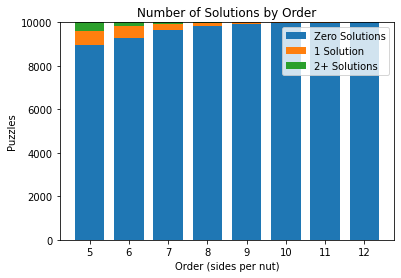

In [11]:
has_0_sln, has_1_sln, has_2_sln = list(zip(*results))
labels = list(map(str, ns))

fig, ax = plt.subplots()
width = 0.75
t = ax.bar(labels, has_0_sln, width, label='Zero Solutions')
ax.bar(labels, has_1_sln, width, label='1 Solution', bottom=has_0_sln)
ax.bar(labels, has_2_sln, width, label='2+ Solutions', bottom=list(map(add, has_0_sln, has_1_sln)))

ax.set_ylabel("Puzzles")
ax.set_xlabel("Order (sides per nut)")
ax.set_title("Number of Solutions by Order")
ax.legend()

plt.show()

In conducting this analysis, there would occassionally be puzzles that had substantially more solutions than average. In particular, there were occasionally `n = 6` puzzles with 6 solutions. Once, there was the following 6th-order puzzle with _eight_ solutions, which I thought was impressive:



In [9]:
puzzle = [
	(1, 2, 5, 3, 4, 6),
	(1, 5, 3, 2, 4, 6),
	(1, 2, 3, 4, 5, 6),
	(1, 5, 6, 3, 4, 2),
	(1, 5, 3, 4, 2, 6),
	(1, 2, 6, 4, 5, 3),
	(1, 3, 2, 6, 4, 5)
]

solutions = solve_puzzle(puzzle, all=True)
print("\n".join(map(str, solutions)))

State: SOLUTION; C: 1/2/5/3/4/6; Placed: 1/5/3/2/4/6, 2/6/4/5/3/1, 5/1/3/2/6/4, 3/4/5/6/1/2, 4/2/6/1/5/3, 6/3/4/2/1/5; Remaining: -
State: SOLUTION; C: 1/2/5/3/4/6; Placed: 1/5/3/2/4/6, 2/6/4/5/3/1, 5/1/3/2/6/4, 3/4/2/6/1/5, 4/5/6/1/2/3, 6/3/4/2/1/5; Remaining: -
State: SOLUTION; C: 1/2/5/3/4/6; Placed: 1/5/3/2/4/6, 2/6/4/5/1/3, 5/3/4/2/6/1, 3/1/2/6/4/5, 4/5/6/1/2/3, 6/3/4/2/1/5; Remaining: -
State: SOLUTION; C: 1/2/5/3/4/6; Placed: 1/5/3/2/4/6, 2/6/4/5/1/3, 5/3/1/2/6/4, 3/4/5/6/1/2, 4/2/6/1/5/3, 6/3/4/2/1/5; Remaining: -
State: SOLUTION; C: 1/2/5/3/4/6; Placed: 1/5/3/2/4/6, 2/6/4/5/1/3, 5/3/1/2/6/4, 3/4/2/6/1/5, 4/5/6/1/2/3, 6/3/4/2/1/5; Remaining: -
State: SOLUTION; C: 1/2/5/3/4/6; Placed: 1/5/3/4/2/6, 2/6/4/5/1/3, 5/3/2/4/6/1, 3/1/2/6/4/5, 4/5/6/1/2/3, 6/3/4/2/1/5; Remaining: -
State: SOLUTION; C: 1/5/3/4/2/6; Placed: 1/5/3/2/4/6, 5/6/1/2/3/4, 3/4/6/1/2/5, 4/5/3/1/2/6, 2/6/4/5/1/3, 6/3/4/2/1/5; Remaining: -
State: SOLUTION; C: 1/2/6/4/5/3; Placed: 1/5/3/4/2/6, 2/6/4/5/1/3, 6/3/4/2/1